# Primary Notebook

## Purpose

The purpose of this notebook is the creation of the clusters.
Those (landscape) clusters are supposed to be areas similar in appearance;
To be more precise, these clusters share a common "FFT footprint" which will be elaborated on later.

## Other parts of this project

There are secondary notebooks, that might have to be run beforehand, to receive data which this primary notebook will work upon.

In [291]:
# What we might need eventually
# rasterio for geotiffs
# dask array for parallel computing of large arrays
# pyfftw for 2d fft 

## Overview of the classes and their interconnection
The subject of this notebook is to cluster different landscapes across multiple DEM-GeoTIFFs. 

### GeographicBounds
This is an object that saves West, South, East, North borders, as well as the projection, and maybe some other additional info.

### AugmentedDEM
This will be the "container" for all information regarding *one* specific DEM raster map.

### EmbeddingMap
This will be part of each AugmentedDEM. Here we will save the labels created by the clustering.




## How to make the GeoTIFF images usable by my algorithm:
It’s important to note, that the original DEM data is in arc seconds. To avoid skewed results it has to be compressed by cos(latitude) in width.  That way the metric distances (almost) resemble the distances pixel-wise

After that the images will be scaled to 1/4 (as of now), because processing becomes about 4^2 times faster.

Before processing, the data will have to be split up into quadratic tiles which are supposed to be equal in their length.

I guess we should combine the processes, namely selecting tiles of equal size and then reducing their size to a given size in pixels

In [292]:
# Imports

# Filesystem, JSON
import os
import json
from io import BytesIO # To be able to route the API response to a file-like object that rasterio can use

# Rasterio for handling GeoTIFFs
import rasterio
from rasterio.transform import Affine
from rasterio.windows import from_bounds


# Math may not be missing
import math
import numpy as np

# Regex for updating filenames
import re

# For earth related numbers
from pyproj import Geod
geod = Geod(ellps="WGS84")

# Matplotlib for checks
import matplotlib.pyplot as plt

In [293]:
# Settings for running this Notebook

internal_settings = {}

internal_settings["files"] = {}
internal_settings["files"]["dem_folder"] = "geotiffs" #Here the to-be-used-geotiffs are located

internal_settings["fft"] = {}
internal_settings["fft"]["tile_size_km"] = 1.75 #average length and width of a tile that is processed individually
internal_settings["fft"]["tile_size_km"] = 55 # For Testing Purposes larger
internal_settings["fft"]["tile_size_px"] = 60

temporary_settings = {}
temporary_settings["augmented_dems"] = []

In [294]:
# Define classes specific to this project 

# This class is supposed to store coordinates for tiles and maybe coordinate systems in the future
class GeographicBounds:
    def __init__(self, west, south, east, north):
        self.west = west
        self.north = north
        self.east = east
        self.south = south

    @property
    def center_x (self): # Center longitude
        return (self.west+self.east)/2

    @property
    def center_y (self): # Center latitude
        return (self.north+self.south)/2

    @property
    def height_degrees (self): # Height in kilometres
        return (abs(self.south - self.north))

    @property
    def width_degrees (self): # Height in kilometres
        return min (abs(self.east - self.west), 360 - abs(self.east - self.west));  #when getting to ±180° it should choose the shorter width # CAUTION, this might be not the final solution

    @property
    def height_km (self): # Height in kilometres
        return (abs(self.south - self.north) / 360.0) * math.pi * 2.0 * geod.b / 1000.0
   
    @property
    def width_north_km (self): # North width in kilometres
        return (abs(self.west - self.east) / 360.0) * math.pi * 2.0 * geod.a * math.cos( math.radians(self.north) ) / 1000.0 
   
    @property
    def width_south_km (self): # North width in kilometres
        return (abs(self.west - self.east) / 360.0) * math.pi * 2.0 * geod.a * math.cos( math.radians(self.south) ) / 1000.0 

    # Return information about the object (for to be used in a print statement for example)
    def __str__(self):
        infostring = "Infos about the GeographicBounds (all rounded):\n"
        infostring += f"-----\n"
        infostring += f"Geographic Bounds:\n"
        infostring += f"West: {self.west:>8.2f}° \n"
        infostring += f"South: {self.south:>7.2f}° \n"
        infostring += f"East: {self.east:>8.2f}° \n"
        infostring += f"North: {self.north:>7.2f}\n"
        infostring += f"-----\n"
        infostring += f"Northern Width: {self.width_north_km:.2f} km\n"
        infostring += f"Southern Width: {self.width_south_km:.2f} km\n"
        infostring += f"Height: {self.height_km:.2f} km\n"
        infostring += f"-----\n"
        infostring += f"Center (lon E, lat N): {self.center_y:.3f}°, {self.center_x:.3f}°\n"
        infostring += "\n"
        return infostring
    
    def as_list(self):
        return [self.west, self.south, self.east, self.north]
    



# This class will contain information about each geotiff that is used for the fft calculations
class AugmentedDEM:
    def __init__(self, dem_path):
        with rasterio.open(dem_path) as dem_file:
            self.geo_bounds = GeographicBounds(dem_file.bounds.left, 
                                               dem_file.bounds.bottom,
                                               dem_file.bounds.right,
                                               dem_file.bounds.top)
        self.dem_path = dem_path


    def CalculateTileBounds(self): # alternative implementation that gives back the borders and stuff in degrees
        # Height of a tile in degrees
        tile_height_degrees = 360 * internal_settings["fft"]["tile_size_km"] * 1000 /  (math.pi * 2.0 * geod.b)

        relative_start_y = (self.geo_bounds.height_degrees % tile_height_degrees) / 2
        absolute_start_y = (self.geo_bounds.north - relative_start_y)
        absolute_end_y = (self.geo_bounds.south + relative_start_y)
        number_tiles_y = int(self.geo_bounds.height_degrees // tile_height_degrees)

        absolute_borders_y = np.linspace(absolute_start_y, absolute_end_y, number_tiles_y + 1 )
        absolute_centers_y = np.linspace(absolute_start_y - (tile_height_degrees / 2), absolute_end_y + (tile_height_degrees / 2), number_tiles_y )


        # Here will go the X-splitting. X will be split with a different tile_width_degrees for each centers_y
        # That is due to the fact that x inside a sector of the earth’s surface is getting smaller in direction of the poles (cos)
        # This is why this is a list of np.arrays and not a 2D np-array (as length varies for each row!)

        absolute_borders_x = []
        self.tile_bounds = []

        
        for i, center_y in enumerate(absolute_centers_y):
            tile_width_degrees = 360 * internal_settings["fft"]["tile_size_km"] * 1000 /  (math.pi * 2.0 * geod.a)  / math.cos (math.radians(center_y))
            
            relative_start_x = (self.geo_bounds.width_degrees % tile_width_degrees) / 2
            absolute_start_x = (self.geo_bounds.west + relative_start_x)
            absolute_end_x = (self.geo_bounds.east - relative_start_x)
            number_tiles_x = int(self.geo_bounds.width_degrees // tile_width_degrees)

            tmp_absolute_borders_x = np.linspace(absolute_start_x, absolute_end_x, number_tiles_x + 1 )
            tmp_absolute_centers_x = np.linspace(absolute_start_x + (tile_width_degrees / 2), absolute_end_x - (tile_width_degrees / 2), number_tiles_x)

            absolute_borders_x.append( np.array(tmp_absolute_borders_x) )

        
        for y in range(len(absolute_centers_y-1)):
            for x in range(len(absolute_borders_x[y])-1):
                self.tile_bounds.append(
                    GeographicBounds(absolute_borders_x[y][x],
                                    absolute_borders_y[y],
                                    absolute_borders_x[y][x+1],
                                    absolute_borders_y[y+1]))
                
    def GetTiles(self):
        with rasterio.open(self.dem_path) as source:
            tile_bounds_np = np.array([bnd.as_list() for bnd in self.tile_bounds])
            num_tiles = len(tile_bounds_np)
            self.tiles_resampled = np.empty((num_tiles, 
                              internal_settings["fft"]["tile_size_px"], 
                              internal_settings["fft"]["tile_size_px"]), dtype = source.dtypes[0])

            for i, bound in enumerate(tile_bounds_np):
                src_window = from_bounds(bound[0], bound[3], bound[2], bound[1], source.transform) 
                tile_resampled = source.read(
                    out_shape = (source.count, 
                                 internal_settings["fft"]["tile_size_px"], 
                                 internal_settings["fft"]["tile_size_px"]),
                                 window = src_window,
                                 resampling = rasterio.enums.Resampling.cubic
                )

                self.tiles_resampled[i] = tile_resampled

    
    
    def DumpTiles(self):
        for i, tile in enumerate(self.tiles_resampled):
            height = internal_settings["fft"]["tile_size_px"]
            width = internal_settings["fft"]["tile_size_px"]

            # Calculate pixel resolution (degrees per pixel)
            res_x = ((self.tile_bounds[i].east - self.tile_bounds[i].west) / width)
            res_y = ((self.tile_bounds[i].north - self.tile_bounds[i].south) / height)

            # Create affine transform (pixel coordinates → WGS84)
            transform = Affine.translation(self.tile_bounds[i].west, self.tile_bounds[i].south) * Affine.scale(res_x, res_y)

            filepath = f"tile_dump/{self.tile_bounds[i].west:.3f}_{self.tile_bounds[i].north:.3f}.tif"

            # Write GeoTIFF
            with rasterio.open(
                filepath,
                "w",
                driver="GTiff",
                height=height,
                width=width,
                count=1, 
                dtype=tile.dtype,
                crs="EPSG:4326", 
                transform=transform,
            ) as dst:
                dst.write(tile[np.newaxis,:])


        

        



In [295]:
# Put all the DEM maps from the dem_folder into the dem_files
with os.scandir(internal_settings["files"]["dem_folder"]) as dirlist:
    temporary_settings["augmented_dems"] =[AugmentedDEM(d.path) for d in dirlist if re.search(r"\.tif",d.name)]



In [296]:
# %%timeit -n 10 -r 10
# Testing
for d in temporary_settings["augmented_dems"]:
    d.CalculateTileBounds()
    d.GetTiles()
    d.DumpTiles()



In [297]:
print(geod.a)

6378137.0


In [298]:
import pyfftw 

# Testing
d = temporary_settings["augmented_dems"][0]


fft_input_array = pyfftw.empty_aligned((len(d.tiles_resampled),
                                        internal_settings["fft"]["tile_size_px"],
                                        internal_settings["fft"]["tile_size_px"]),
                                        dtype = "complex64")

fft_output_array =  pyfftw.empty_aligned((len(d.tiles_resampled),
                                        internal_settings["fft"]["tile_size_px"],
                                        internal_settings["fft"]["tile_size_px"]),
                                        dtype = "complex64")

fft_execution_plan = pyfftw.FFTW(fft_input_array,
                                 fft_output_array, axes=(1,2),
                                 direction="FFTW_FORWARD",
                                 flags=("FFTW_MEASURE",))

fft_input_array[:] = temporary_settings["augmented_dems"][0].tiles_resampled #Important. [:] ensures the reserved empty array is used, and no new one is created! It will not work without that special slicing.

fft_execution_plan.execute()

fft_magnitude_spectra = np.log(np.abs(fft_output_array) + 1) 



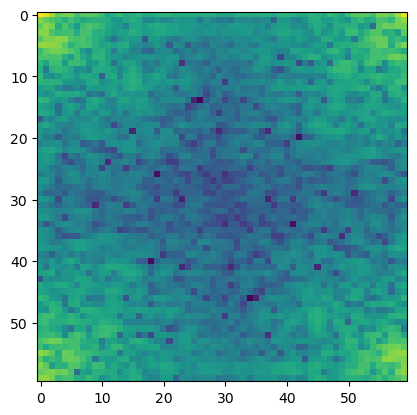

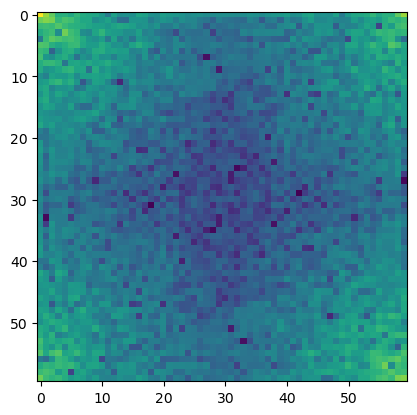

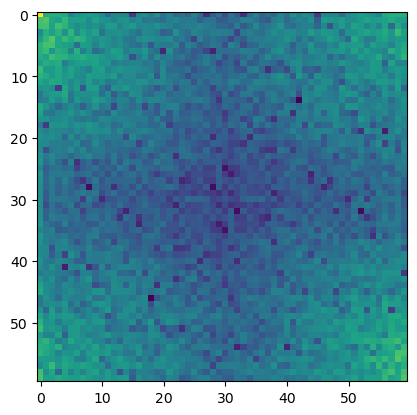

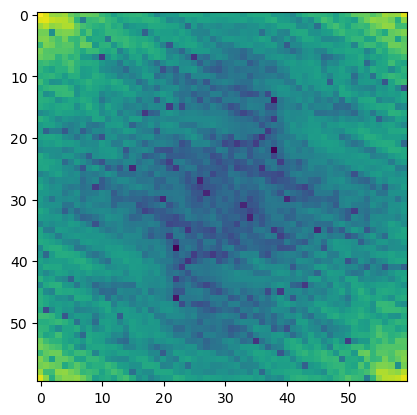

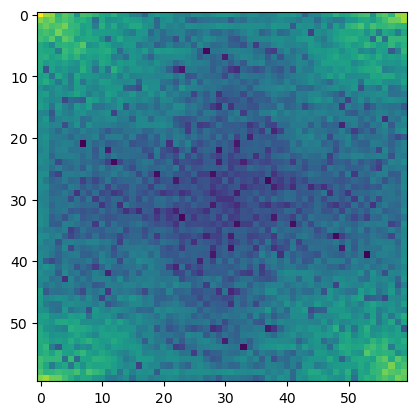

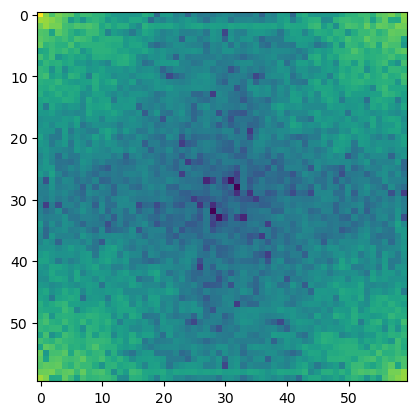

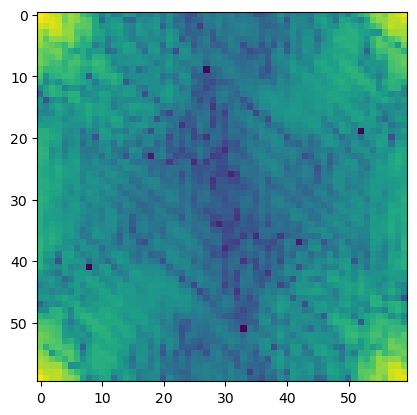

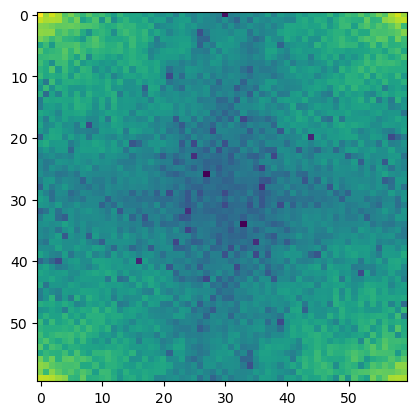

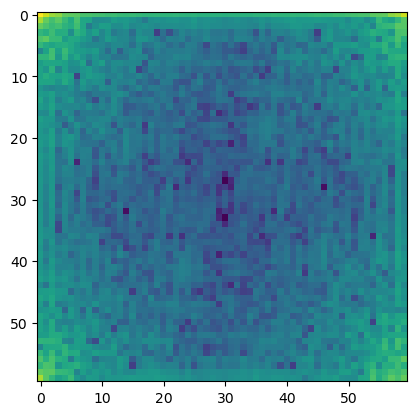

In [299]:
for picture in fft_magnitude_spectra:
    plt.imshow(picture)
    plt.show()
    plt.close()

## Code to be refactored and integrated: